# Дообучение RoBERTa для задачи анализа тональности отзывов
Глазунов А.В.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/'My Drive'/Colab_Notebooks/bert

/content/gdrive/My Drive/Colab_Notebooks/bert


In [3]:
!pip install transformers

     |████████████████████████████████| 778kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 9.2MB/s 
     |████████████████████████████████| 890kB 16.6MB/s 
     |████████████████████████████████| 3.0MB 27.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=2f2afe2db1941283e5d93f8a12e2f9f4a82ee45e1ca35570d4d135d940169ede
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import torch 
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [5]:
df_train = pd.read_csv('data/products_sentiment_train.tsv',header=None,sep='\t')
df_test = pd.read_csv('data/products_sentiment_test.tsv',header=0,sep='\t')

In [6]:
df_train.head()

,0,1
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [7]:
df_test.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


In [8]:
df_train.columns = ["text","label"]
df_train.head()

,text,label
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [9]:
df_train.label.value_counts()

1    1274
0     726
Name: label, dtype: int64

In [10]:
lengths = df_train.text.apply(lambda x: len(x.split()))
lengths

0        8
1       25
2       28
3       33
4       18
        ..
1995    17
1996     9
1997     5
1998    29
1999    16
Name: text, Length: 2000, dtype: int64

In [11]:
max_len = np.max(lengths)
max_len

92

In [12]:
lengths_test = df_test.text.apply(lambda x: len(x.split()))
lengths_test

0      43
1      23
2       9
3      11
4      13
       ..
495    22
496     7
497    13
498    11
499     5
Name: text, Length: 500, dtype: int64

In [13]:
max_len_test = np.max(lengths_test)
max_len_test

106

In [14]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_val, y_train,y_val = train_test_split(
    df_train.text.values,
    df_train.label.values,
    shuffle=True,
    test_size = 0.15,
    random_state=17,
    stratify=df_train.label.values
)

In [18]:
X_train.shape,X_val.shape

((1700,), (300,))

In [19]:
from transformers import RobertaTokenizer
from torch.utils.data import TensorDataset

In [20]:
tokenizer = RobertaTokenizer.from_pretrained(
   'roberta-base'
)

In [21]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=2*max_len ,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=2*max_len ,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)


input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [22]:
dataset_train = TensorDataset(input_ids_train,
                             attention_masks_train,
                             labels_train)
dataset_val = TensorDataset(input_ids_val,
                             attention_masks_val,
                             labels_val)

In [23]:
len(dataset_train)

1700

In [24]:
len(dataset_val)

300

In [25]:
from transformers import RobertaForSequenceClassification

In [26]:
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels = 2,
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [28]:
batch_size = 16#32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [29]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [30]:
optimizer = AdamW(
    model.parameters(),
    lr= 1e-5,#the original paper:2e-5 -> 5e-5
    eps=1e-8,
    weight_decay=10
)

In [31]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat,preds_flat)                   

In [34]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')#xm.xla_device() 
model.to(device)

print(device)

cuda


In [36]:
def evaluate(dataloader):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [37]:
epochs=10

In [38]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train,
                        desc = 'Epoch: {:1d}'.format(epoch),
                       leave=False, disable=False)
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids'      : batch[0],
            'attention_mask' : batch[1],
            'labels'         : batch[2]
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)    
    tqdm.write(f'Training_loss: {loss_train_avg}')
    

    _, predictions_train, true_train_vals = evaluate(dataloader_train)
    val_loss, predictions_val, true_vals = evaluate(dataloader_val)

    train_acc = accuracy_score_func(predictions_train, true_train_vals)
    val_acc = accuracy_score_func(predictions_val, true_vals)
    
    tqdm.write(f'Train accuracy score: {train_acc}')
    tqdm.write(f'Validation_loss: {val_loss}')
    tqdm.write(f'Validation accuracy score: {val_acc}')


Epoch 1
Training_loss: 0.474629563444825



Train accuracy score: 0.9435294117647058
Validation_loss: 0.27026824202192457
Validation accuracy score: 0.91



Epoch 2
Training_loss: 0.22810942376746196



Train accuracy score: 0.9647058823529412
Validation_loss: 0.26465524943839563
Validation accuracy score: 0.92



Epoch 3
Training_loss: 0.16026751084740612



Train accuracy score: 0.9823529411764705
Validation_loss: 0.3356972810273108
Validation accuracy score: 0.91



Epoch 4
Training_loss: 0.11968222413882265



Train accuracy score: 0.9788235294117648
Validation_loss: 0.4128947606016147
Validation accuracy score: 0.9033333333333333



Epoch 5
Training_loss: 0.07428610914008187



Train accuracy score: 0.9947058823529412
Validation_loss: 0.4452485504382486
Validation accuracy score: 0.9133333333333333



Epoch 6
Training_loss: 0.04546505864383218



Train accuracy score: 0.9952941176470588
Validation_loss: 0.4708377898082529
Validation accuracy score: 0.9266666666666666



Epoch 7
Training_loss: 0.017219833724492307



Train accuracy score: 0.9982352941176471
Validation_loss: 0.523964480147697
Validation accuracy score: 0.9066666666666666



Epoch 8
Training_loss: 0.00747212296771756



Train accuracy score: 0.9982352941176471
Validation_loss: 0.5528083493210081
Validation accuracy score: 0.91



Epoch 9
Training_loss: 0.008959897618118464



Train accuracy score: 0.9994117647058823
Validation_loss: 0.5903222297048686
Validation accuracy score: 0.9066666666666666



Epoch 10
Training_loss: 0.017086430784058103



Train accuracy score: 1.0
Validation_loss: 0.6042692090452061
Validation accuracy score: 0.9033333333333333



In [41]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [42]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [43]:
model.load_state_dict(
    torch.load('Models/BERT_ft_epoch2.model',
              map_location=torch.device('cuda')))

<All keys matched successfully>

In [44]:
_, predictions, true_vals = evaluate(dataloader_val)

In [45]:
accuracy_score_func(predictions, true_vals)

0.92

In [58]:
encoded_data_test = tokenizer.batch_encode_plus(
    df_test.text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=2*max_len ,
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(np.zeros(df_test.text.shape).astype(int))

dataset_test = TensorDataset(input_ids_test,
                             attention_masks_test,
                             labels_test)


dataloader_test = DataLoader(
    dataset_test,
    sampler=SequentialSampler(dataset_test),
    batch_size=batch_size
)



Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [59]:
def predict(dataloader):

    model.eval()
    
    predictions = []
    
    for batch in tqdm(dataloader):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],                  
                  'labels':         batch[2]
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        
        logits = outputs[1]
        
        logits = logits.detach().cpu().numpy()
        
        predictions.append(logits)
        
      
    predictions = np.concatenate(predictions, axis=0)
    preds_flat = np.argmax(predictions,axis=1).flatten()
    
    return preds_flat

In [48]:
preds = predict(dataloader_test)
preds

array([0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,

In [49]:
ans = pd.DataFrame({'Id' : df_test.Id, 'y' : preds})
ans

,Id,y
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
495,495,0
496,496,1
497,497,0
498,498,1


In [50]:
ans.to_csv('submission_roberta1.csv', index=False)

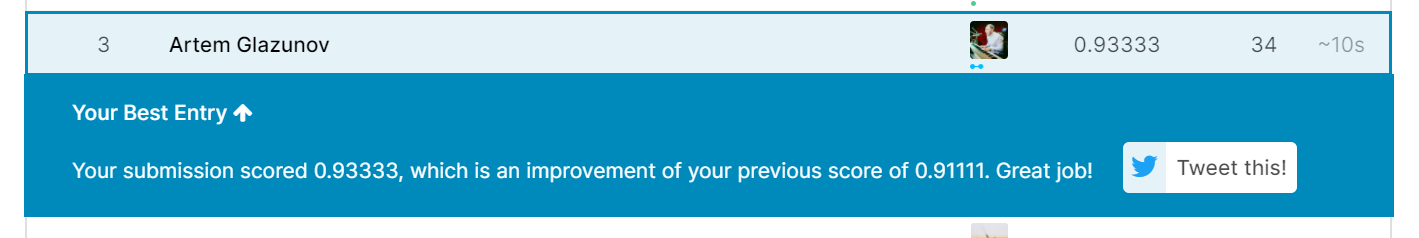

In [53]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [54]:
model.to(device)
pass

In [55]:
model.load_state_dict(
    torch.load('Models/BERT_ft_epoch6.model',
              map_location=torch.device('cuda')))

<All keys matched successfully>

In [56]:
_, predictions, true_vals = evaluate(dataloader_val)

In [57]:
accuracy_score_func(predictions, true_vals)

0.9266666666666666

In [61]:
preds = predict(dataloader_test)
preds

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,

In [62]:
ans = pd.DataFrame({'Id' : df_test.Id, 'y' : preds})
ans

,Id,y
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
495,495,0
496,496,1
497,497,0
498,498,1


In [63]:
ans.to_csv('submission_roberta2.csv', index=False)

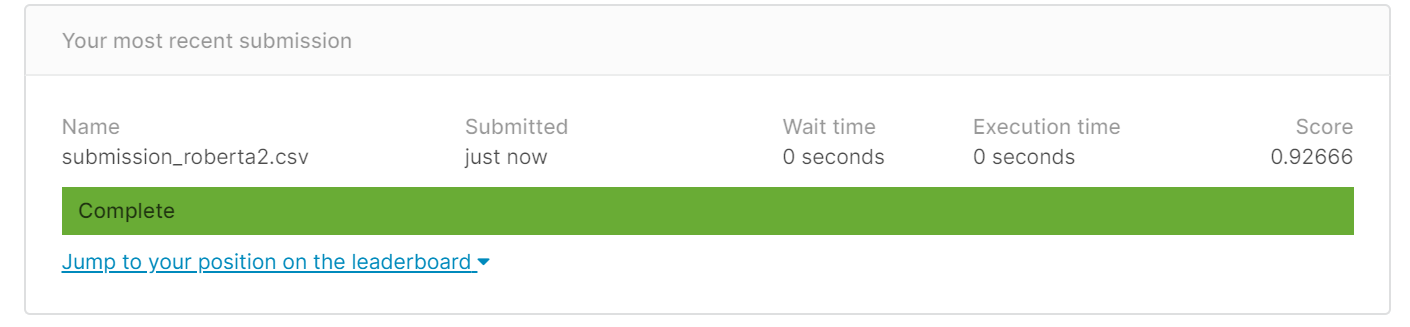